# Project - Day 3 - Deploy you model (in a notebook)

In the main notebook of the today exercise, we developed and trained a Convolutional Neural Network 🥞 for distinguishing electron recoil events from Nuclear Recoil events that are more expected to be associated to Dark Matter collisions 💥.

We concluded that notebook by storing on Minio the classification model.

In this notebook we will retrieve the model from Minio and we will deploy it to classify the preprocessed events as prepared during Day 2.

Developing this step in a dedicated notebook, will enable injecting it in a distributed pipeline as we will discuss tomorrow.

## Loading libraries, data and model

### Loading libraries

In [23]:
## We will be using Numpy, Pyplot and Tensorflow as our scientific tool box
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf

## Minio for accessing the data and the stored models 
from minio import Minio

## BytesIO for defining in-memory file-like objects
from io import BytesIO

## Dask and in particular dask array for defining OOM pipelines
import dask
import dask.array as da

## Progress bars
from tqdm import tqdm

### Listing data objects stored in Minio
You should now have a wealth of about 24 hours of data taking stored in your Minio. If you were succesful yesterday, the data stored on Minio should be preprocessed as well. 

But since files are uploaded automatically by the pipeline, as a first thing we need a list of what is available in the bucket.

So,
 * connect to your Minio instance
   ```python
   minio = Minio(..., secure=False)
   ```
 * list the objects in the preprocessing bucket (as you chose it in day 2, maybe `cygno-preprocessed`?), check [the method `.list_objects`](https://min.io/docs/minio/linux/developers/python/API.html#list_objects) in the Minio docs.
 * Obtain the list of object names from the list of objects
   ```python
   object_names = [obj.object_name for obj in <your_list_of_objects>]
   ```
 * Sort your list of object names
   ```python
   object_names = sorted(object_names)
   ```


In [2]:
## Solution
minio = Minio("localhost:9000", "sosc_participant", "Perugia2023", secure=False)
list_of_objects = minio.list_objects('cygno-preprocessed')
object_names = [obj.object_name for obj in list_of_objects]
object_names = sorted(object_names)

print (f"Found {len(object_names)} objects in bucket. "
       f"Spanning from `{object_names[0]}` to `{object_names[-1]}`.")

Found 11998 objects in bucket. Spanning from `data-chunk-2023-10-06T06:03:18.615485.npz` to `data-chunk-2023-10-09T08:14:13.285935.npz`.


### Load the latest file

The following snippet of code allows to load a numpy file directly from Minio, given the bucket and the object names.

```python
def load_npz_from_minio(minio_client, bucket_name, object_name):
  """Load an object from Minio into a numpy array"""
  return np.load(
    BytesIO(
       minio_client.get_object(bucket_name, object_name).data
    )
  )
```

Try to use this function to load the latest object name (as defined in `object_names[-1]`). 

You can use the following function to inspect the content of a 
numpy file as the one you have just downloaded:
```python
def inspect_np(npz_file):
    """Display key, shape and dtype of the arrays in a npz file"""
    keys = np_file.keys()
    print ("Keys in file: ", ", ".join(keys))
    for key in keys:
        array = np_file[key]
        print (
            f" - {key:<15s}"
            f"   shape: {str(array.shape):<20s}"
            f"   dtype: {array.dtype}"
          )
```


In [16]:
## Solution
def load_npz_from_minio(minio_client, bucket_name, object_name):
  """Load an object from Minio into a numpy array"""
  return np.load(
    BytesIO(
       minio_client.get_object(bucket_name, object_name).data
    )
  )


def inspect_np(npz_file):
    """Display key, shape and dtype of the arrays in a npz file"""
    keys = np_file.keys()
    print ("Keys in file: ", ", ".join(keys))
    for key in keys:
        array = np_file[key]
        print (
            f" - {key:<15s}"
            f"   shape: {str(array.shape):<20s}"
            f"   dtype: {array.dtype}"
          )

npz_file = load_npz_from_minio(minio, 'cygno-preprocessed', object_names[-1])
inspect_np(npz_file)

Keys in file:  image, tstamp
 - image             shape: (10, 128, 128)         dtype: uint8
 - tstamp            shape: (10,)                  dtype: datetime64[us]


### Create a dask delayed function to download images and timestamps

Consider and test the following function for obtaining a specific array from a generic npz object stored in Minio.
```python
@dask.delayed
def load_array_from_minio(minio_client, bucket_name, object_name, npz_key):
    """Load an array identified by npz_key from an npz file in Minio"""
    npz = load_npz_from_minio(minio_client, bucket_name, object_name)
    return npz[npz_key] 
```

Create a list of delayed dask arrays for the images and the timestamps. 
For example for the images you should have something like:
```python
delayed_images = [
    da.from_delayed(
        load_array_from_minio(minio, 'cygno-preprocessed', obj, 'image'),
        shape=(10, 128, 128),
        dtype=np.float64
    )
    for obj in object_names
]
```

And finally, you can use `da.concatenate` con create a single array out of the many files you are ready to download.


In [18]:
## Solution

@dask.delayed
def load_array_from_minio(minio_client, bucket_name, object_name, npz_key):
    """Load an array identified by npz_key from an npz file in Minio"""
    npz = load_npz_from_minio(minio_client, bucket_name, object_name)
    return npz[npz_key] 

delayed_images = [
    da.from_delayed(
        load_array_from_minio(minio, 'cygno-preprocessed', obj, 'image'),
        shape=(10, 128, 128),
        dtype=np.float64
    )
    for obj in object_names
]

images = da.concatenate(delayed_images)


### 
delayed_tstamps = [
    da.from_delayed(
        load_array_from_minio(minio, 'cygno-preprocessed', obj, 'tstamp'),
        shape=(10,),
        dtype=np.float64
    )
    for obj in object_names
]

tstamps = da.concatenate(delayed_tstamps)

display(images)
display(tstamps)

dask.array<concatenate, shape=(119980, 128, 128), dtype=float64, chunksize=(10, 128, 128), chunktype=numpy.ndarray>

dask.array<concatenate, shape=(119980,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>

#### Cross-check: list the latest 15 timestamps

Now, to check that the pipeline works as expected, you may want to list the latest 15 time stamps and cross-check that the DAQ and the preprocessing are still alive. 

```python
tstamps[-15:].compute()
```

In [19]:
## Solution
tstamps[-15:].compute()

array(['2023-10-09T08:13:46.385805', '2023-10-09T08:13:48.110910',
       '2023-10-09T08:13:50.461323', '2023-10-09T08:13:51.079653',
       '2023-10-09T08:13:54.347671', '2023-10-09T08:13:55.195469',
       '2023-10-09T08:13:58.289226', '2023-10-09T08:13:58.801495',
       '2023-10-09T08:14:05.038638', '2023-10-09T08:14:05.272348',
       '2023-10-09T08:14:05.943870', '2023-10-09T08:14:07.945624',
       '2023-10-09T08:14:09.454424', '2023-10-09T08:14:10.509310',
       '2023-10-09T08:14:13.285935'], dtype='datetime64[us]')

### Load the classifier model

Retrieve the keras model of the trained classifier from Minio using S3 and store it locally, for example in the file `./classifier.keras`, and then load it in keras.

You may get started with the following function calls:
```python
## Download an object from Minio to Keras
minio.fget_object('cygno-models', 'classifier.keras', "classifier.keras")

# Load the model file in Keras
classifier = tf.keras.models.load_model('classifier.keras')
```

In [21]:
## Download an object from Minio to Keras
minio.fget_object('cygno-models', 'classifier.keras', "classifier.keras")

# Load the model file in Keras
classifier = tf.keras.models.load_model('classifier.keras')

2023-10-09 08:46:26.331534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 145d3b2e882a
2023-10-09 08:46:26.331596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 145d3b2e882a
2023-10-09 08:46:26.331676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-10-09 08:46:26.331750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2


## Evaluate the model

You can now use the `predict_on_batch` function of keras to run the model on each block of the loaded images.

Don't forget to rechunk the array of images to make avoid applying the neural network to each stored data file, separately (it would take forever).

> 💡**Hint.**
> You may want to check:
>  * [the method `dask.array.rechunk`](https://docs.dask.org/en/latest/generated/dask.array.rechunk.html)
>  * [the method `keras.models.Model.predict_on_batch`](https://keras.io/api/models/model_training_apis/#predictonbatch-method)

> 🧑‍🔬**Professional Tip.** More effective Dask.
> 
> If you are seeking for a skill-up in Dask, you may also want to check
> [the method `.map_partitions`](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.map_partitions.html).
> It requires some additional boiler-plate to work with respect to the
> simple loop on blocks discussed in the [CVonEMNIST notebook](./CVonEMNIST.ipynb),
> but it enables better parallelism and more efficient computing.

In the following cells, we will assume that the output of the evaluation of the neural network has been stored in a variable named `predictions`.


In [47]:
## Solution

## Rechunk the image
rechunked_images = images.rechunk((10000, -1, -1))

## Evaluate the CNN model on the batches and concatenate the outputs
predictions = np.concatenate([
    classifier.predict_on_batch(x).flatten()
    for x in tqdm(rechunked_images.blocks, total=rechunked_images.numblocks[0])
])

100%|██████████| 12/12 [00:50<00:00,  4.19s/it]


### Histogram of the responses
🗹 If everything worked fine so far, you should be able to reproduce a plot similar to the one below by running the following code snippet.

```python
def plot_histogram(predictions):
    """Makes a histogram of the CNN predictions for the CYGNO-SIM acquired data"""
    plt.hist(yhat, bins=np.linspace(0, 1, 51), label="CYGNO-SIM")
    plt.yscale('log')
    plt.xlabel("Response of the CNN")
    plt.ylabel("Number of acquired events")
    plt.legend()
    plt.show()

plot_histogram(predictions)
```

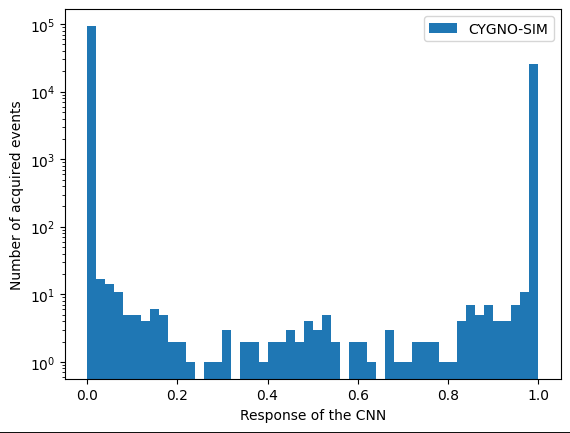

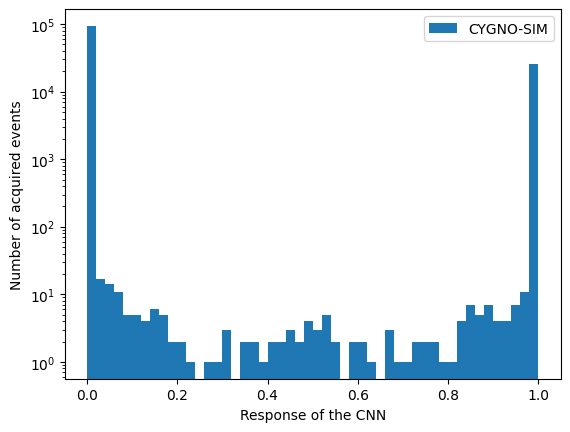

In [51]:
## Solution
def plot_histogram(predictions):
    """Makes a histogram of the CNN predictions for the CYGNO-SIM acquired data"""
    plt.hist(yhat, bins=np.linspace(0, 1, 51), label="CYGNO-SIM")
    plt.yscale('log')
    plt.xlabel("Response of the CNN")
    plt.ylabel("Number of acquired events")
    plt.legend()
    plt.show()

plot_histogram(predictions)

## Studying the time dependence 

Tune the following code snippet to create the histogram of the counts that are more likely to be due to Nuclear Recoils.

In case of an evidence for Dark Matter, you may expect a *seasonal* modulation. 
Since the SOSC cannot last one year, in our simulated DAQ, seasons change with a period of 3 hours. ... 

*you know... there are no more mid-seasons... it's winter 5 minutes after it's summer...*


```python
def make_timestamp_histogram(
    timestamps, 
    predictions,
    threshold,
    bin_width=0.1,
):
    """
    Creates a histogram of the selected events in hourly bins.

    Arguments:
     - timestamps:  dask array of type np.datetime64
     - predictions: numpy array of the classifier response with the same 
                    shape as timestamps
     - threshold:   float, threshold in range [0,1] defining the minimum
                    classifier's response to select a candidate event as NR
     - bin_width:   float, approximate dimension of a bin in hours, default: 0.1

    Returns:
     - a tuple of 1D arrays (time_in_hours, number_of_selected_events)
    """
    ## Obtain the timestamps as a numpy array
    np_tstamps = timestamps.compute()

    ## Retrieve the first timestmp as "START"
    t0 = np_tstamps[0]

    ## Select only the timestamps associated to a positive response
    ## of the CNN classifier
    t = np_tstamps[predictions > threshold]

    ## Convert the timestamp in a number of hours since START
    hours_since_start = (t-t0)/np.timedelta64(1, 'h')

    ## Compute the end of the time span as LATEST
    tot_hours = hours_since_start.max()

    ## Compute the number of bins as the first integer exceeding 
    ## the total number of hours divided per the width of each bin
    bins = int(np.ceil(tot_hours / bin_width))

    ## Fill a histogram of "hours since start"
    n_selected_events, boundaries = np.histogram(hours_since_start, bins=bins)

    ## Given the boundaries obtained from the histogram, compute the 
    ## center of each bin
    time_in_hours = 0.5 * (boundaries[1:] + boundaries[:-1])

    ## Return the tuple with the center of the bin and the number of selected
    ## events falling in that bin
    return time_in_hours, n_selected_events

##############
## Retrieve the histogram of counts for events more likely to be due to 
## nuclear recoil
t, counts = make_timestamp_histogram(tstamps, predictions, 0.9)

## Assuming Poissonian distribution of the contents, assess the uncertainty 
## on the counts
error = np.sqrt(predictions)

## Plot the histogram
plt.figure(figsize=(12,3))
plt.xlabel("Time [h]")
plt.ylabel("Selected events")
plt.errorbar (t, counts, np.sqrt(contents), fmt='ko')
```


<ErrorbarContainer object of 3 artists>

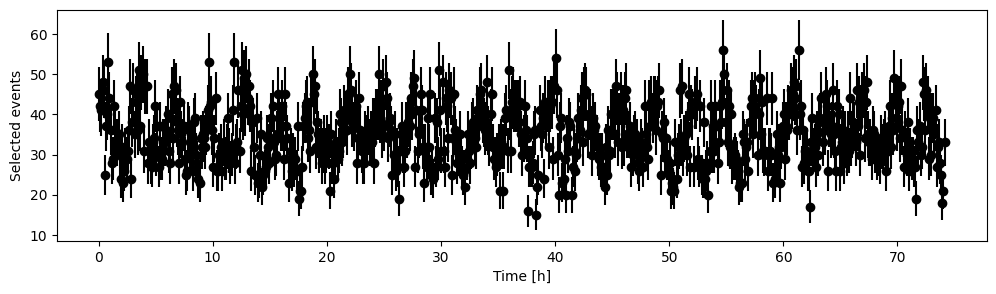

In [72]:
def make_timestamp_histogram(
    timestamps, 
    predictions,
    threshold,
    bin_width=0.1,
):
    """
    Creates a histogram of the selected events in hourly bins.

    Arguments:
     - timestamps:  dask array of type np.datetime64
     - predictions: numpy array of the classifier response with the same 
                    shape as timestamps
     - threshold:   float, threshold in range [0,1] defining the minimum
                    classifier's response to select a candidate event as NR
     - bin_width:   float, approximate dimension of a bin in hours, default: 0.1

    Returns:
     - a tuple of 1D arrays (time_in_hours, number_of_selected_events)
    """
    ## Obtain the timestamps as a numpy array
    np_tstamps = timestamps.compute()

    ## Retrieve the first timestmp as "START"
    t0 = np_tstamps[0]

    ## Select only the timestamps associated to a positive response
    ## of the CNN classifier
    t = np_tstamps[predictions > threshold]

    ## Convert the timestamp in a number of hours since START
    hours_since_start = (t-t0)/np.timedelta64(1, 'h')

    ## Compute the end of the time span as LATEST
    tot_hours = hours_since_start.max()

    ## Compute the number of bins as the first integer exceeding 
    ## the total number of hours divided per the width of each bin
    bins = int(np.ceil(tot_hours / bin_width))

    ## Fill a histogram of "hours since start"
    n_selected_events, boundaries = np.histogram(hours_since_start, bins=bins)

    ## Given the boundaries obtained from the histogram, compute the 
    ## center of each bin
    time_in_hours = 0.5 * (boundaries[1:] + boundaries[:-1])

    ## Return the tuple with the center of the bin and the number of selected
    ## events falling in that bin
    return time_in_hours, n_selected_events

##############
## Retrieve the histogram of counts for events more likely to be due to 
## nuclear recoil
t, counts = make_timestamp_histogram(tstamps, predictions, 0.9)

## Assuming Poissonian distribution of the contents, assess the uncertainty 
## on the counts
error = np.sqrt(predictions)

## Plot the histogram
plt.figure(figsize=(12,3))
plt.xlabel("Time [h]")
plt.ylabel("Selected events")
plt.errorbar (t, counts, np.sqrt(contents), fmt='ko')

## Build a statistical model for the seasonal oscillation

What we expect is a seasonal modulation of the event count due to a dark matter wind. 

Mathematically, we can describe the rate of observed and selected events as:
$$
\frac{dN_{NR}}{dt} = b + s\left[1 + \sin\left(\frac{2\pi}{T}t + \varphi\right)\right]
$$
where:
 - $b$ is the rate of *background events* which is not subject to a seasonal oscillation, it may be due to misidentified *Electron Recoils* or to physics background resulting in nuclear recoils;
 - $s$ is the amplitude of the modulation, or the maximal event rate due to DM interaction during the seasonal modulation;
 - $T$ is the period of the seasonal modulation;
 - $\varphi$ is the phase of the seasonal modulation.

Given the histogram described in the previous cells, one can make reasonable assumptions on the vale of $s$ and $b$, 
$$
b \approx \min_i \left.\frac{dN_{NR}}{dt}\right|_i
\qquad
\mbox{and}
\qquad
s \approx \frac{1}{2}\left[ \max_i \left.\frac{dN_{NR}}{dt}\right|_i - b\right]
$$

while for the period of the modulation we rely on our *astromagical* model that says we expect cycles of 3 hours.
$$
T \approx 3\,\mathrm{h}
$$
In a real experiment we would also have an expectation for the phase, here we are referring time to an arbitrary START, so the phase is also arbitrary.


### Implement the statistical model in TensorFlow
Below you can find an implementation of the model in TensorFlow.

```python
## Global variables defining the free parameters of the model
b = tf.Variable(float(np.min(contents)))
s = tf.Variable(float(np.max(contents) - np.min(contents))/2)
T = tf.Variable(3.)
phi = tf.Variable(0.)

def fitfun(x):
    """Statistical model"""
    return b + s * (1 + tf.sin(2*np.pi * x/T + phi))
```

### Define a loss function and minimizing it
Since we have an uncertainty associated to each data point, we can use a $\chi^2$ as a custom loss.

$$
\chi^2 = \sum_k \frac{(O_k - E_k(b, s, T, \varphi))^2}{O_k}
$$
where $O_k$ represents the number of entries observed in the $k$-th bin and $E_k$ the expectation according to the model.

In TensorFlow, 
```python
def chi2():
    """Custom loss for least-squared method"""
    return tf.reduce_sum((counts - fitfun(t))**2 / counts)
```

### Optimize the custom loss

Finally, define an optimizer, its learning rate and a number of iterations.

```python
learning_rate = <your_learning rate>
optimizer = tf.keras.optimizers.Adam(learning_rate)

losses = []
for epoch in range(<number_of_iterations>):
    optimizer.minimize(chi2, var_list=[b, s, T, phi])
    losses.append (chi2().numpy())
```

Plotting the evolution of the loss might be of major help in defining the values for the learning rate and the number of iterations.

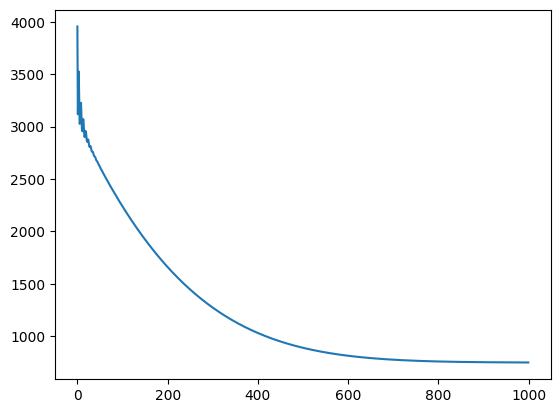

In [70]:
b = tf.Variable(float(np.min(contents)))
s = tf.Variable(float(np.max(contents) - np.min(contents))/2)
T = tf.Variable(3.)
phi = tf.Variable(0.)

def fitfun(x):
    return b + s * (1 + tf.sin(2*np.pi * x/T + phi))

def chi2():
    return tf.reduce_sum((counts - fitfun(t))**2 / counts)

optimizer = tf.keras.optimizers.Adam(3e-2)

losses = []
for epoch in range(1000):
    optimizer.minimize(chi2, var_list=[b, s, T, phi])
    losses.append (chi2().numpy())

plt.plot(losses)

## Draw the "final plot" 

Finally, you can produce the plot comparing hte fitted model to the observed data rate, by tuning the following snippet of code.

```python
## Plot the histogram
plt.figure(figsize=(12,3))
plt.xlabel("Time [h]")
plt.ylabel("Selected events")
plt.errorbar (t, counts, np.sqrt(contents), fmt='ko')
## Superpose the fitted model
plt.plot(t, fitfun(t), label="Fitted model", linewidth=3, color='red', zorder=10)
plt.legend()
plt.show()
```

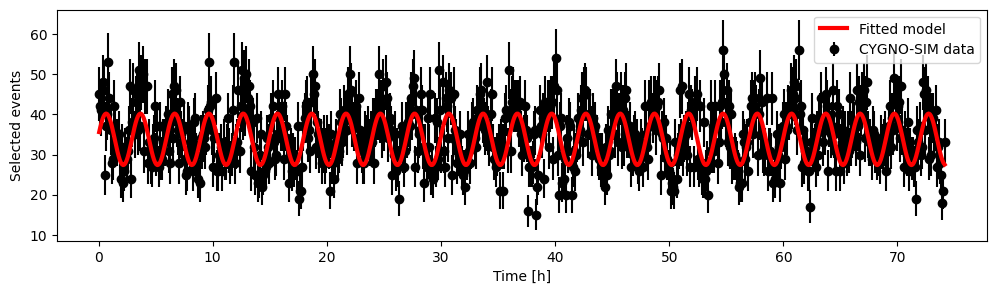

In [76]:
## Plot the histogram
plt.figure(figsize=(12,3))
plt.xlabel("Time [h]")
plt.ylabel("Selected events")
plt.errorbar (t, counts, np.sqrt(contents), fmt='ko', label="CYGNO-SIM data")
## Superpose the fitted model
plt.plot(t, fitfun(t), label="Fitted model", linewidth=3, color='red', zorder=10)
plt.legend()
plt.show()

## Conclusion

In this notebook we have deployed a model stored on Minio and we fed it with the preprocessed data that your pipeline based on NATS has automatically uploaded to storage. 

Then we have analysed the data by performing a simple (probably simplistic) least-squared fit that enable to measure of the signal-to-background rate of our experiment.

Where to go from here?
 - You might try to replace the preprocessing step with a dask pipeline reading directly from the DAQ bucket instead of using a dockerized preprocessing step;
 - You will learn how to insert a notebook in a workflow to keep updating the result as new data are acquired (for example for monitoring or real-time analysis purpose);
 - You can explore different thresholds and different models to explore enhance your DM signature.